# Housing Data

Following along with Ch. 2 of "Hands-On Machine Learning with Scikit-Learn and TensorFlow" by Aurelien Geron.

## Table of Contents
***
### 1. Data Set
* 1.1 Reading the data in
* 1.2 Exploring the data
* 1.3 Initial Visualization
* 1.4 Creating Training & Test Sets

### 2. Data Cleaning & Feature Engineering
* 2.1 Outliers/NaN Values
* 2.2 Fixing missing values
* 2.3 Correlation & Feature Engineering
* 2.4 One-Hot Encoding/Dummy Variables

### 3. Model Selection
***

In [83]:
# Important dataframe and math packages
import pandas as pd
import numpy as np

# Visualization packages
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline

# Machine Learning packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Model packages
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Saving/importing models
# from sklearn.externals import joblib

## 1. Data Set

### 1.1 Reading the data in

In [84]:
housing = pd.read_csv('../input/housing.csv')

### 1.2 Exploring the data

***
After we have read in our data, a good thing to do is take an initial glance at the data itself. There are several good functions for this such as `head()`, `info()`, and `describe()`. The `head()` function shows us the first five entries (you can change how many you see) in our dataset with all the values and columns.
***

In [85]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


***
The `info()` function lets you see how many elements are in each column and their data types. This is an initial good way to check to see if there is any missing data.
***

In [86]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


***
If we want to see some descriptive information about our dataset using the `describe()` command. This tells us several things for each column: 
* number of elements
* mean 
* std 
* min/max 
* quartile ranges

This only returns numerical values and will ignore columns with non-numerical entries.
***

In [87]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


***
We can even go one step further look at how many unique values or labels there are in a particular column by using `value_counts()` function.
***

In [88]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### 1.3 Initial Visualization

***
An important step, just like taking a first look at what the data contains, is to visualize the data. To do this, let's plot some figures.

Since this is housing data for California let's make a scatter plot of the latitude and longitude using a heat map of `median_house_value` and making the size of each point defined by the population
***

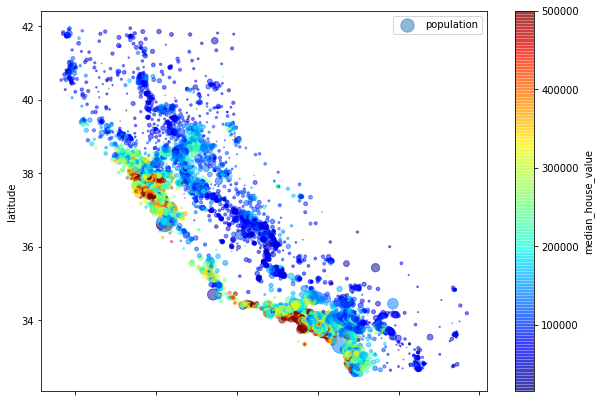

In [89]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5,
            s=housing['population']/100, label='population',figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True);

***
This plot shows what we expect to see: houses with higher prices are typically found near urban centers. Next, let's plot a histogram of the dataset.
***

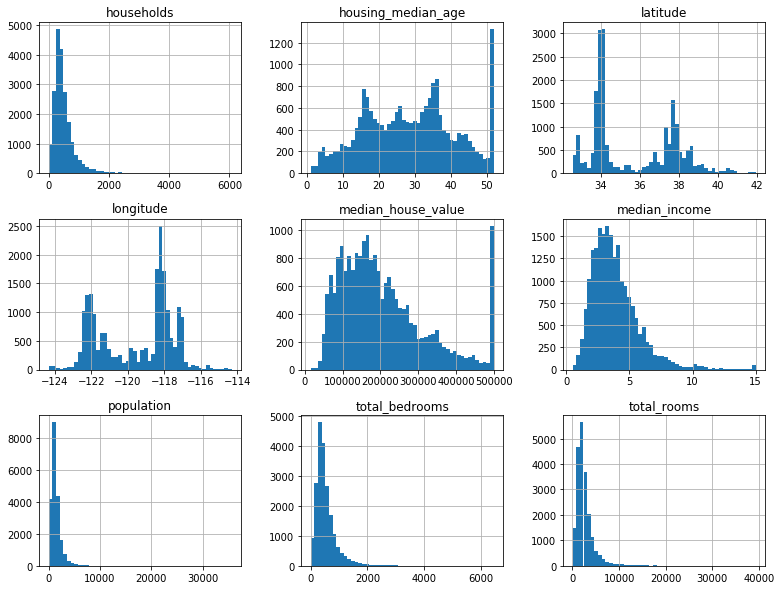

In [90]:
housing.hist(bins=50,figsize=(13,10))
plt.show()

***
Notice that none of the plots are normally distributed and have distinct peaks and skewedness. We will have to deal with this later in addition to things like missing values. For now, however, we have done enough preliminary exploration of the data to get a sense of what it contains and what we want to do with it.
***

### 1.4 Creating Training & Test Sets

***
Before we move on to checking for missing values or an imputation or manipulating the data in any way we need to create a training set and a test/validation set. This is to avoid a *data snooping bias* which occurs when we know a little too much about our data and develop biases on what we expect to happen. There are several methods to do this (you can write one by hand, but why re-invent the wheel?) and depending on how your data is distributed will determine which method we use. 

If our data had been roughly normally distributed we could use the `train_test_split()` function from Sci-kit Learn, however, as the histograms above show we don't have a normally distributed dataset. In this case we can use Sci-kit Learn's `StratifiedShuffleSplit` function as it doesn't take a random sample of data but a stratified selection (random data taken from layers depending on how many datapoints in a layer so we get the same distribution in the training and test sets).

If the median income is an important predictor variable we should look at the histogram to see the spread. From above, the median income is mostly in the 2-5 range, however it is mostly continuous data. We want to separate into what are called *strata* so we can create an income category attribute. 
***

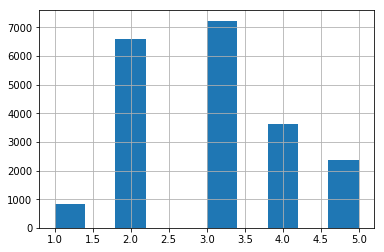

In [91]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].hist();

***
Now that our data has been separated into strata we can employ `StratifiedShuffleSplit` to make our training and test sets.
***

In [92]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    X_train = housing.loc[train_index]
    X_test = housing.loc[test_index]

***
Now let's check how the data was split up.
***

In [93]:
X_test['income_cat'].value_counts() / len(X_test)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

***
`StratifiedShuffleSplit` splits up the dataset very close to the full dataset's distribution, while random sampling is much worse. Now we need to remove the income category that we created so the data is back to original.
***

In [94]:
for tset in (X_train,X_test):
    tset.drop('income_cat', axis=1, inplace=True)

## 2. Data Cleaning & Feature Engineering

### 2.1 Outliers/NaN Values

***
Now that we have our training/test sets we should make sure there are no more outliers or missing values.
***

In [95]:
X_train.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [96]:
X_train.total_bedrooms.isnull().sum()

158

***
There are 158 null/NaN values in the total_bedrooms column of our training set. We have a couple options at this point: we can drop the column with missing values (not a good idea), we can drop the rows with missing data (better than the entire column but we don't really want to do this either), or we can replace the missing values (usually with the mean, median, or mode). 

The third option is the better option and can be accomplished manually or through Sci-kit Learn's `SimpleImputer` function. `SimpleImputer` only works with numerical values so we will have to drop any categorical columns.
***

### 2.2 Fixing missing values

In [97]:
#housing.dropna(subset=['total_bedrooms']) # Don't do this
#housing.drop('total_bedrooms') # Or this

# This is the better manual option
#median = housing['total_bedrooms'].median()
#housing['total_bedrooms'].fillna(median, inplace=True)

In [98]:
# Create new variables with the ocean_proximity data for later
X_traincat = X_train['ocean_proximity']
X_testcat = X_test['ocean_proximity']

# Impute values in both sets and convert to dataframes
imputer = SimpleImputer(strategy='median')

for tset in (X_train,X_test):
    tset.drop('ocean_proximity', axis=1, inplace = True)
    
imputer.fit(X_train)
X1 = imputer.transform(X_train)
X_train = pd.DataFrame(X1, columns=X_train.columns)

imputer.fit(X_test)
X2 = imputer.transform(X_test)
X_test = pd.DataFrame(X2, columns=X_test.columns)

***
And one final check to make sure we aren't missing any more values.
***

In [99]:
print(X_train.isnull().any().sum(),X_test.isnull().any().sum())

0 0


### 2.3 Correlation & Feature Engineering

***
Now our dataset is ready to work with. At this point it is a good idea to check correlation between variables and see if we can't create some better features.

The heat map plot above shows that housing price is correlated to population density, at least according to our eyes. To explore correlation further we can calculate *Pearson's r* using the `corr()` function, comparing every feature against median_house_value.
***

In [100]:
corr_matrix = X_train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047642
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

***
*Pearson's r* ranges from -1 to 1 with -1 indicating a negative linear relationship between variables while a 1 indicates a positive linear relationship. A weakness of *Pearson's r* is that it only measures linear relationships and no others.

Another way to look at the correlation coefficient is visually using Panda's `scatter_matrix`.
***

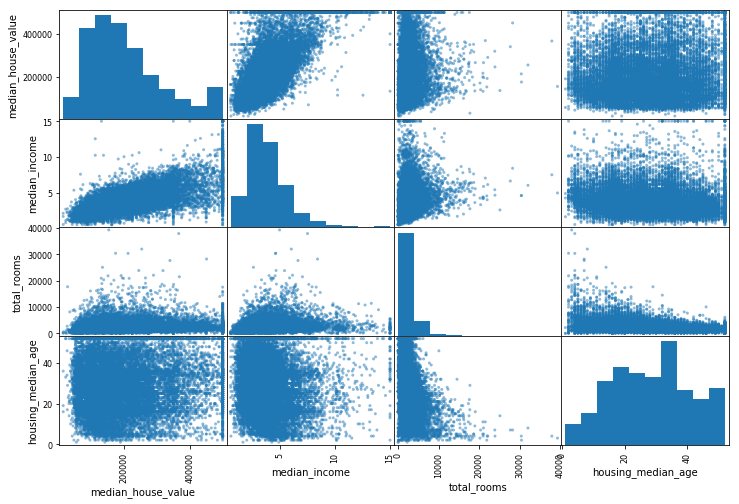

In [101]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(X_train[attributes], figsize=(12,8));

***
This outputs a histogram matrix that helps us visualize correlation as there are some patterns in data that seem correlated via *Pearson's r* but isn't visually correlated when plotted. Let's also take a closer look at median_house_value vs. median_income.
***

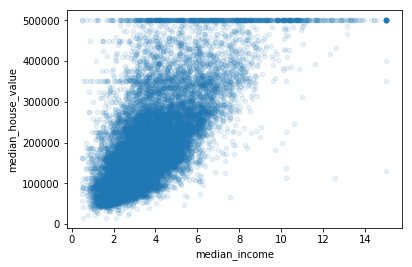

In [102]:
X_train.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

***
This shows a strong linear correlation but also has some horizontal lines that will throw off a best fit line slightly. But, for now, let's look at other combinations for correlation by making a couple new features.

We can create several new combination features from old ones and test their correlation:
* rooms_per_household measures the number of rooms per household per district
* bedrooms_per_room measures the number of bedrooms per room per district
* population_per_household measures the population vs households per district
***

In [103]:
# Remember to transform both sets at the same time so you don't forget!
for sets in (X_train,X_test):
    sets['rooms_per_household'] = sets['total_rooms'] / sets['households']
    sets['bedrooms_per_room'] = sets['total_bedrooms'] / sets['total_rooms']
    sets['population_per_household'] = sets['population'] / sets['households']

# Correlation matrix
corr_matrix = X_train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047642
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.234240
Name: median_house_value, dtype: float64

***
The new additions seem to be a little more correlated to the `median_house_value` than most of the normal features with `bedrooms_per_room` being more correlated (negatively) than either `rooms_per_household` or `population_per_household`.
***

### 2.4 One-Hot Encoding/Dummy Variables

***
We've created some new features to work with but we did drop the categorical feature that tells us how far away from the ocean a district is when we imputed the missing values earlier. Now is the time to add those back in and convert them into one-hot vectors (also called dummy variables) using Sci-kit Learn's `OneHotEncoder`.
***

In [104]:
# X_traincat and X_testcat were our variables with ocean_proximity that we saved 
# before removing them to impute
x1_cat_encoded, x1_categories = X_traincat.factorize()
x2_cat_encoded, x2_categories = X_testcat.factorize()

# One-Hot Encoder
encoder = OneHotEncoder()
x1_cat_1hot = encoder.fit_transform(x1_cat_encoded.reshape(-1,1))
x2_cat_1hot = encoder.fit_transform(x2_cat_encoded.reshape(-1,1))
x1_cat = x1_cat_1hot.toarray()
x2_cat = x2_cat_1hot.toarray()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

***
Now we have our one-hot arrays but in the conversion they become floats which we don't really want as our values are just a yes or no, not some continuous value. This step isn't completely necessary but I find it is easier to read int values than floats.
***

In [105]:
x1_cat.astype(int)
x2_cat.astype(int)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

***
Before we put these arrays back into the training and test sets we should check their shape to make sure nothing got lost.
***

In [106]:
x1_cat.shape,x2_cat.shape,X_train.shape,X_test.shape

((16512, 5), (4128, 5), (16512, 12), (4128, 12))

In [107]:
# Now we make a loop to create new columns in both data sets of our one-hot values
a = 0
for sets in (X_train,X_test):
    i = 0
    if a == 0:
        var = x1_cat
    else:
        var = x2_cat
    for name in ('<1H OCEAN','INLAND','NEAR OCEAN','NEAR BAY','ISLAND'):
        sets[name] = var[:,i].astype(int) # convert to int because these shouldn't be floats
        i += 1
    a += 1

***
One last check to make sure adding the columns to the sets worked properly.
***

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 17 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
total_bedrooms              16512 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
median_house_value          16512 non-null float64
rooms_per_household         16512 non-null float64
bedrooms_per_room           16512 non-null float64
population_per_household    16512 non-null float64
<1H OCEAN                   16512 non-null int64
INLAND                      16512 non-null int64
NEAR OCEAN                  16512 non-null int64
NEAR BAY                    16512 non-null int64
ISLAND                      16512 non-null int64
dtypes: float64(12), int64(5)
memo

***
Last step before beginning to pick a model is to drop the labels from the training/test sets and create label vectors.
*******

In [109]:
X_train_labels = X_train['median_house_value']
X_train.drop('median_house_value',axis=1,inplace = True)
X_test_labels = X_test['median_house_value']
X_test.drop('median_house_value',axis=1,inplace = True)

## 3. Model Selection

***
In this section we aren't going to go through the normal process of building 5+ generic models without tuning hyperparameters (which you should!) as this isn't intended to actually be a submitted model but a learning guide. That being the case we are just going to pick a couple basic models to look at.
***

### 3.1 Linear Regressor

***
First up is a linear regressor which just applied basic linear regression to our observed data values. This isn't the best model as, just like the name suggests, it essentially creates a best-fit line. But, our data isn't necessarily linear so it has the chance to underfit pretty badly (it will in this case).

Linear models are fairly quick to implement and they do give us some idea of what is going on so it isn't a bad idea to run one before looking at more complex models. To do this we are going to use Sci-kit Learn's `LinearRegression` function.
***

In [110]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,X_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

***
This has trained our model on the training set and labels, so now we predict with the test set.
***

In [111]:
predicts = lin_reg.predict(X_train)
lin_mse = mean_squared_error(X_train_labels,predicts)
lin_mse = np.sqrt(lin_mse)
lin_mse

68628.19819848922

***
To check the results we use Sci-kit Learn's `mean_squared_error` (MSE) function which checks how far off the mark we are. This results in a typical prediction errors of over \$68,000...not very good. This shows that our data isn't necessarily linear and should try another model.
***

### 3.2 Decision Tree Regressor

***
The next kind of model we will look at is a Decision Tree Regressor. This type of regressor is similar to the linear regressor but functions more like its namesake taking branching paths through the features to label an input with the appropriate label (or what it thinks is appropriate).
***

In [112]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,X_train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [113]:
predicts2 = tree_reg.predict(X_train)
tree_mse = mean_squared_error(X_train_labels,predicts2)
tree_mse = np.sqrt(tree_mse)
tree_mse

0.0

***
Checking the MSE we get a 0. No model is 100% accurate, however, which means we vastly overfit the data.
***

### 3.3 Cross-Validation

***
To help with the overfitting we can cross-validate but running the decision tree multiple times then averaging the result to lower bias. To do this we use Sci-kit Learn's `cross_val_score` function that takes a model as its main argument and also a term `cv` that tells how many runs to do.
***

In [114]:
scores = cross_val_score(tree_reg,X_train,X_train_labels,scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)
print('Scores:',tree_rmse_scores)
print('Mean:',tree_rmse_scores.mean())
print('Standard Deviation:',tree_rmse_scores.std())

Scores: [69350.82006366 66107.4616771  72184.46921547 69464.39707308
 70851.37827308 75179.48802154 70587.46172942 69535.41218653
 76391.97873907 70395.36442618]
Mean: 71004.82314051427
Standard Deviation: 2822.4452071902865


***
This shows that the error of \$68000 wasn't some one off value. We either need more robust data or to choose a model that will work better. We can do a little better with the ensemble (putting together several methods into one) version of the Decision Tree Regressor, the Random Forest Regressor.
***

### 3.4 Random Forest Regressor

***
This model is implemented just like the previous ones, the only difference is we call the `RandomForestRegressor` function.
***

In [115]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,X_train_labels)
predicts3 = forest_reg.predict(X_train)
forest_rmse = mean_squared_error(X_train_labels,predicts3)
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22477.72983131484

***
We went from an error of \$68-70,000 down to $22300, much better! We can try for a little better with cross-validation.
***

In [116]:
scores = cross_val_score(forest_reg,X_train,X_train_labels,scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-scores)
print('Scores:',forest_rmse_scores)
print('Mean:',forest_rmse_scores.mean())
print('Standard Deviation:',forest_rmse_scores.std())

Scores: [52058.81959817 51398.55426327 51601.55805362 53189.54889188
 52042.78322638 56432.69905065 52078.50782718 51157.63448614
 56106.61609144 52088.97839753]
Mean: 52815.56998862619
Standard Deviation: 1803.4977820990975


In [117]:
# If you want to save your model so you don't need to rerun it everytime use pickle
# from sklearn.externals import joblib
# Export
# joblib.dump(my_model, 'my_model.pkl')
# Import
# my_model_loaded = joblib.load('my_model.pkl')

### 3.5 Fine Tuning Models

***
Once we have a couple models we want to try and got some preliminary results we should try to fine tune our models to find the optimal variables that balance accuracy with efficiency. You could do this manually but Sci-kit Learn has a handy function for doing this already, `GridSearchCV`. All you need to do is pass `GridSearchCV` a grid of parameters to check, how many times to cross-validate, a model, and the scoring that you want (here we are using the MSE).
***

In [118]:
param_grid = [{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
              {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring = 'neg_mean_squared_error')
grid_search.fit(X_train,X_train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

***
`GridSearchCV` has a handy attribute called `best_estimator_` that returns which parameters for the model you tested are best.
***

In [119]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

***
Or if you just want to see the best parameters from the grid you specified you can call `best_params_`.
***

In [120]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

***
You can also use `cv_results_` to print out the score with each parameter combination that was checked.
***

In [121]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

64320.397616666414 {'max_features': 2, 'n_estimators': 3}
55627.78128232532 {'max_features': 2, 'n_estimators': 10}
52679.661391851434 {'max_features': 2, 'n_estimators': 30}
61090.05311802028 {'max_features': 4, 'n_estimators': 3}
53024.40270801134 {'max_features': 4, 'n_estimators': 10}
50952.23729654177 {'max_features': 4, 'n_estimators': 30}
58939.652979289196 {'max_features': 6, 'n_estimators': 3}
52512.13985891984 {'max_features': 6, 'n_estimators': 10}
50036.925635253036 {'max_features': 6, 'n_estimators': 30}
58625.73114670854 {'max_features': 8, 'n_estimators': 3}
52022.85337326566 {'max_features': 8, 'n_estimators': 10}
50146.95720107937 {'max_features': 8, 'n_estimators': 30}
61955.72907029293 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54569.72071504897 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59945.16648359989 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52378.634401725794 {'bootstrap': False, 'max_features': 3, 'n_estimators

## Evaluate on test set

***
The best combination from above (it wasn't an exhaustive search and a better search would implement a random grid search) was `max_features = 6` and `n_estimators = 30` so we can put those in and evaluate our model on our test set.
***

In [122]:
final = RandomForestRegressor(max_features=8,n_estimators=30)
final.fit(X_train,X_train_labels)
final_predicts = final.predict(X_test)
final_rmse = mean_squared_error(X_test_labels,final_predicts)
final_rmse = np.sqrt(final_rmse)
final_rmse

76662.78708935287

***
This didn't predict the value very well as the RMSE (root mean squared error) is higher than when we ran it on the training set. While our general method of testing models is sound, this high of an error says that we need to look back at our initial data set up as the problems most likely lie there (we have big outliers and normalizing the data first would help immensely but we will not do that here). 

But, for a first pass this is a good introduction about the general method for approaching a machine learning problem.
***